In [1]:
import matplotlib.pylab as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 12

path = "/Library/Fonts/NanumGothic.otf"
font_name = fm.FontProperties(fname=path, size=20).get_name()

plt.rc('font', family=font_name)

In [2]:
import statsmodels.api as sm

호흡기 질환 사망자 수에 대한 시계열 자료를 보자.

In [3]:
data = sm.datasets.get_rdataset("accdeaths", "MASS")

In [4]:
df = data.data

def yearfraction2datetime(yearfraction, startyear=0):
    import datetime
    import dateutil
    year = int(yearfraction) + startyear
    month = int(round(12 * (yearfraction - year)))
    delta = dateutil.relativedelta.relativedelta(months=month)
    date = datetime.datetime(year, 1, 1) + delta
    return date

In [5]:
df.tail()

,time,value
67,1978.583333,9827
68,1978.666667,9110
69,1978.750000,9070
70,1978.833333,8633
71,1978.916667,9240


In [6]:
df["datetime"] = df.time.map(yearfraction2datetime)
df.tail()

,time,value,datetime
67,1978.583333,9827,1978-08-01
68,1978.666667,9110,1978-09-01
69,1978.750000,9070,1978-10-01
70,1978.833333,8633,1978-11-01
71,1978.916667,9240,1978-12-01


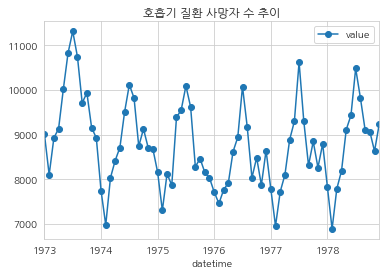

In [8]:
df.plot(x="datetime", y="value", style=["o-"])
plt.title("호흡기 질환 사망자 수 추이")
plt.show()

이 시계열 자체는 낮은 차수의 ARMA 모형으로 모형화하기 힘든 복잡한 시계열이다.

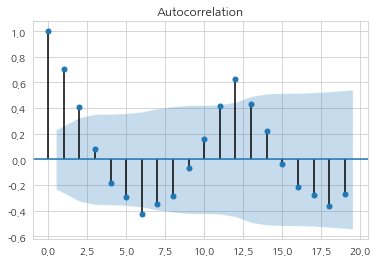

In [9]:
sm.graphics.tsa.plot_acf(df["value"])  # ARMA 모형은 자기상관계수가 시차가 커질 수록 0으로 수렴되어야 함
plt.show()

## 단순 Seasonal ARIMA 모형

Seasonal ARIMA 모형은 줄여서 SARIMA라고 하기도 한다. 

#### 단순 SARIMA 모형은 각 계절에 따른 독립적인 ARIMA 모형이 합쳐져 있는 모형이다. 

기존 ARIMA(p,d,q) 모형에 계절성 주기를 나타내는 차수 s가 추가적으로 필요하기 때문에 SARIMA(P,D,Q,s) 로 표기한다.

s의 값은 월별 계절성을 나타낼 때는  𝑠=12 가 되고 분기별 계절성을 나타낼 때는  𝑠=4 가 된다.

### 단순 Seasonal MA 모형

예를 들어 각 월의 시계열 자료 값이 현재의 백색 잡음 이외에 작년 동월의 백색 잡음에도 영향을 받는다면 다음과 같은 단순 SARIMA(0,0,1,12) 모형이 된다.

$$Y_t = \epsilon_t + \Theta \epsilon_{t-12}$$

이 시계열은 시차(lag)가 12인 경우에는 자기상관계수가 0이 아니고 다른 경우에는 모두 0이된다. 즉, 다른 달끼리는 상관관계가 없다.

$$\text{Cov}[Y_t, Y_{t-1}] = \text{Cov}[ \epsilon_t + \Theta \epsilon_{t-12} ,  \epsilon_{t-1} + \Theta \epsilon_{t-13} ] = 0$$

$$\text{Cov}[Y_t, Y_{t-12}] = \text{Cov}[ \epsilon_t + \Theta \epsilon_{t-12} ,  \epsilon_{t-12} + \Theta \epsilon_{t-24} ] = -\Theta \sigma_e^2$$

이 성질은 MA 차수 Q가 1이 아닌 일반적인 경우에도 성립한다. 예를 들어 다음과 같은 일반적인 단순 SARIMA(0,0,Q,s) 모형의 경우,

$$Y_t = \epsilon_t + \Theta \epsilon_{t-12} + \Theta \epsilon_{t-2\cdot 12} + \cdots + \Theta \epsilon_{t-Q \cdot 12}$$

자기상관계수의 값은 시차가  𝑘𝑠 인 경우에만 0이 아닌 다음과 같은 값이 되고 다른 시차값에 대해서는 0이 된다.

$$\rho_{ks} = \dfrac{\Theta_k + \Theta_{1}\Theta_{k+1} + \Theta_{2}\Theta_{k+2} + \cdots + \Theta_{Q-k}\Theta_{k+Q}}{1 + \Theta_1^2 +\Theta_2^2 + \cdots + \Theta_Q^2}$$

### 단순 Seasonal AR 모형

예를 들어 각 월의 시계열 자료 값이 작년 동월의 자료값 자체에도 영향을 받는다면 다음과 같은 단순 SARIMA(1,0,0,12) 모형이 된다.

$$Y_t = -\Phi Y_{t-12} + \epsilon_t$$

이 확률 과정은 모수  Φ < 1 인 경우에만 정상과정이 된다.

자기상관계수의 값은 시차가  𝑘𝑠 인 경우에만 0이 아닌 다음과 같은 값이 되고 다른 시차값에 대해서는 0이 된다.

$$\rho_{ks} = (-\Phi)^k$$

### 단순 Seasonal ARMA 모형

ARMA(p,q) 모형은 다음과 같이 수식으로 나타낼 수 있다.

$$Y_t = -\phi_1 Y_{t-1} + \phi_2 Y_{t-2}- \cdots -\phi_p Y_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots  + \theta_q \epsilon_{t-q}$$

이를 시간 지연 연산자  𝐿 을 사용하면 다음과 같이 표기하기도 한다.

$$\phi(L)Y_t = \theta(L)\epsilon_t$$

$$\phi(L) = 1 + \phi_1 L + \phi_2 L^2 + \cdots + \phi_p L^p$$

$$\theta(L) = 1 + \theta_1 L + \theta_2 L^2 + \cdots + \theta_q L^q$$

일반적인 단순 Seasonal ARMA (P,Q,S) 모형은 모든 시간 지연이 s의 배수이기 때문에 다음과 같이 표기한다.

$$\phi(L^s)Y_t = \theta(L^s)\epsilon_t$$

이를 풀면 다음과 같은 의미이다.

$$Y_t + \phi_1 Y_{t-s} + \phi_2 Y_{t-2s} + \cdots + \phi_P Y_{t-Ps} = \epsilon_t + \theta_1 \epsilon_{t-s} + \theta_2 \epsilon_{t-2s} + \cdots + \theta_Q \epsilon_{t-Qs}$$

### 단순 Seasonal ARIMA 모형

ARIMA(p,1,q) 모형은 다음과 같이 수식으로 나타낼 수 있다.

$$Y_t-Y_{t-1} + \phi_1 (Y_{t-1}-Y_{t-2}) + \phi_2 (Y_{t-2}-Y_{t-3}) + \cdots + \phi_p (Y_{t-p}-Y_{t-p-1}) = \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots  + \theta_q \epsilon_{t-q}$$

$$\nabla Y_t + \phi_1 \nabla Y_{t-1} + \phi_2 \nabla Y_{t-2} + \cdots + \phi_p \nabla Y_{t-p} = \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}$$

$$\phi(L)\nabla Y_t = \theta(L)\epsilon_t$$

ARIMA(p,d,q) 모형은 다음과 같이 수식으로 나타낼 수 있다.

$$\phi(L)\nabla^d Y_t = \theta(L)\epsilon_t$$

이 식에서  ∇𝑑 는  𝑑 번 차분하는 연산을 의미한다.

단순 Seasonal ARIMA (P,1,Q,S) 모형은 다음과 같이 쓸 수 있다.

$$\phi(L^s)\nabla_s Y_t = \theta(L^s)\epsilon_t$$

이 식에서  ∇𝑠 는  𝑠-시간 지연 차분을 나타낸다. 즉  ∇𝑠𝑌𝑡=𝑌𝑡−𝑌𝑡−𝑠 이다. 이 식을 풀면 다음과 같은 의미이다.

$$(Y_t-Y_{t-s}) + \phi_1 (Y_{t-s}-Y_{t-2s}) + \phi_2 (Y_{t-2s}-Y_{t-3s}) + \cdots + \phi_P (Y_{t-Ps}-Y_{t-(P-1)s}) = \epsilon_t + \theta_1 \epsilon_{t-s}  + \theta_2 \epsilon_{t-2s} + \cdots  + \theta_Q \epsilon_{t-Qs}$$

단순 Seasonal ARIMA (P,D,Q,S) 모형은 다음과 같이 쓸 수 있다.

$$\phi(L^s)\nabla_s^D Y_t = \theta(L^s)\epsilon_t$$

이 식에서  ∇𝑑𝑠 는  𝑠 -시간 지연 차분을  𝐷 번 반복하는 연산을 의미한다.

## 단순 Seasonal ARIMA 모형의 시뮬레이션

다음과 같은 단순 Seasonal MA(1) 모형을 살펴보자.

$$Y_t  =  \epsilon_t + 0.9 \epsilon_{t-12}$$

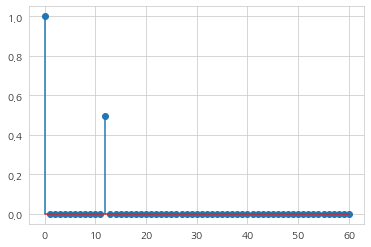

In [11]:
# 모델 생성 및 이론적 자기상관계수 구하기
p1 = sm.tsa.ArmaProcess([1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9])
plt.stem(p1.acf(61), use_line_collection=True)
plt.show()

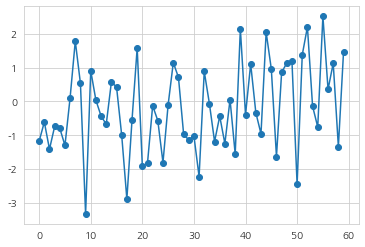

In [14]:
# 샘플 생성
np.random.seed(0)
y1 = p1.generate_sample(1200, burnin=240)
plt.plot(y1[:60], 'o-')
plt.show()

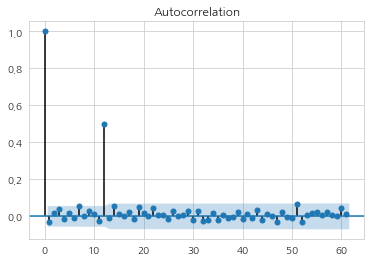

In [15]:
# 샘플의 자기상관계수 구하기
sm.graphics.tsa.plot_acf(y1, lags=61)
plt.show()

다음은 단순 Seasonal AR(1) 모형의 예이다.

$$Y_t = 0.95 Y_{t-12} + \epsilon_t$$

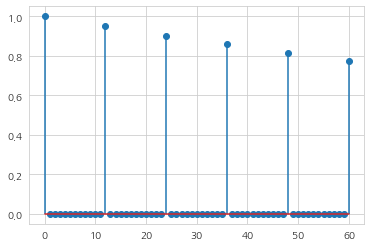

In [16]:
# 모형 생성 및 이론적 자기상관계수 구하기
p2 = sm.tsa.ArmaProcess([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.95], [1])
plt.stem(p2.acf(61), use_line_collection=True)
plt.show()

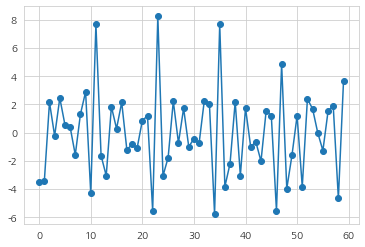

In [19]:
# 샘플 생성
np.random.seed(8)
y2 = p2.generate_sample(1200, burnin=110)
plt.plot(y2[:60], "o-")
plt.show()

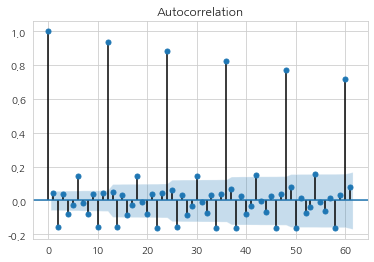

In [20]:
# 샘플의 자기상관계수 구하기
sm.graphics.tsa.plot_acf(y2, lags=61)
plt.show()

다음은 단순 Seasonal ARI(1, 1) 모형의 예이다.

$$Y_t - Y_{t-12} = 0.1(Y_{t-12} - Y_{t-24}) + \epsilon_t$$

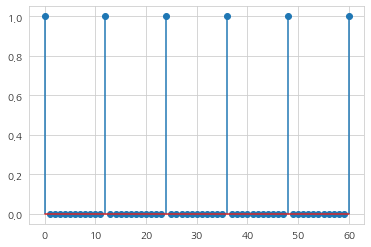

In [24]:
# 모델 생성 및 이론적 상관계수 구하기
p3 = sm.tsa.ArmaProcess([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3], [1])
plt.stem(p3.acf(61), use_line_collection=True)
plt.show()

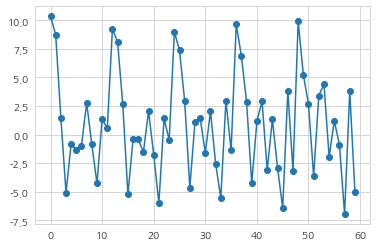

In [25]:
# 샘플생성
np.random.seed(4)
y3 = p3.generate_sample(1200, burnin=120)
plt.plot(y3[:60], "o-")
plt.show()

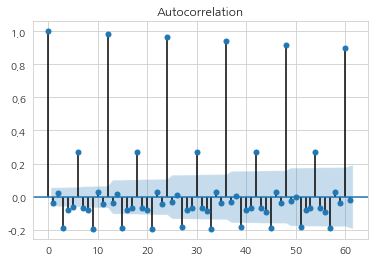

In [26]:
# 샘플의 자기상관계수 구하기
sm.graphics.tsa.plot_acf(y3, lags=61)
plt.show()

## Multiplicated Seasonal ARIMA 모형

단순 Seasonal ARIMA 모형은 다음과 같은 수식으로 표현되면 시간 지연이 모두  𝑠 의 정수배이다.

$$\phi(L^s)\nabla_s^D Y_t = \theta(L^s)\epsilon_t$$

시간 지연이 모두  𝑠 의 정수배이기 때문에 원 시계열 자료는  𝑠 개의 분리된 시계열 자료와 마찬가지이다. 

#### 자기상관계수 함수도 시차가  𝑠 의 정수배인 경우만 0이 아니고 나머지 경우에는 모두 0이다.

그러나 실제 계절성을 보이는 자료에 대해 자기상관계수 함수를 구하면 시차가 s의 정수배인 경우에 큰 값을 보이지만 일반적으로 그 주변의 시차에서도 0이 아닌 유의한 값을 보인다. 

#### 이러한 특성을 모형화 하려면  𝑠 개의 시계열 자료가 완전히 독립적으로 움직이는 것 보다는 그 사이에도 영향을 미치는 일반적인 ARIMA 모형의 특성도 가지고 있어야 한다.

$$\phi(L)\nabla^D Y_t = \theta(L)\epsilon_t$$

이 두 가지 특성을 동시에 가지고 있는 모형을 Multiplicated Seasonal ARIMA (p,d,q)x(P,D,Q,s) 모형이라고 하며 다음과 같은 수식을 따르게 된다.

$$\phi_p(L)\tilde{\phi}_P(L^s)\nabla_s^D\nabla^d Y_t = \theta_q(L)\tilde{\theta}_Q(L^s)\epsilon_t$$

### 예 1: Multiplicated SARIMA(0,0,1)x(0,0,1,12)

예를 들어 다음과 같은 모형은 Multiplicated SARIMA(0,0,1)x(0,0,1,12) 모형이다. 이 모형은 계절주기가 12 이고 12주기 자료간에 ARIMA(0,0,1) 모형 관계가 있고 일반 자료간에 ARIMA(0,0,1)의 관계가 있다.

$$Y_t = (1-\theta L)(1-\Theta L^{12}) \epsilon_t = \epsilon_t + \theta \epsilon_{t-1} + \Theta \epsilon_{t-12} + \theta\Theta \epsilon_{t-13}$$

#### 이 모형의 자기상관계수 함수를 계산하면 시차가 1, 11, 12, 13 인 경우를 제외하고는 0이 된다.

$$\rho_1 = -\dfrac{\theta}{1+\theta^2}$$

$$\rho_{11} = \rho_{13} = \dfrac{\theta\Theta}{(1+\theta^2)(1+\Theta^2)}$$

$$\rho_{12} = -\dfrac{\Theta}{1+\Theta^2}$$

몇가지  𝜃,Θ 값에 대해 이 모형의 자기상관계수 함수를 구하면 다음과 같다.

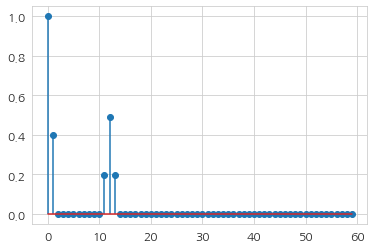

In [30]:
# 모형 생성 및 이론적 자기생성함수 구하기
theta = 0.5
Theta = 0.8
p4 = sm.tsa.ArmaProcess([1], [1, theta, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Theta, theta * Theta])
plt.stem(p4.acf(60), use_line_collection=True)
plt.show()

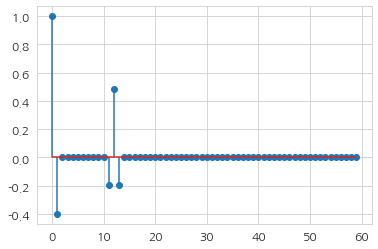

In [31]:
theta = -0.5
Theta = 0.8
p5 = sm.tsa.ArmaProcess([1], [1, theta, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Theta, theta * Theta])
plt.stem(p5.acf(60), use_line_collection=True)
plt.show()

### 예 2: Multiplicated SARIMA(0,0,1)x(1,0,0,12)

또 다른 예로 Multiplicated SARIMA(0,0,1)x(1,0,0,12) 모형을 살펴보자. 이 모형은 주기가 12 인 계절성 요소끼리는 ARMA(1,0) 모형이고 개별 요소끼리는 ARMA(0,1) 모형이다.

$$(1 + \Phi L^{12})Y_t = \epsilon_t + \theta \epsilon_{t-1}$$

$$Y_t =  -\Phi Y_{t-12} + \epsilon_t + \theta \epsilon_{t-1}$$

이 모형의 자기상관계수 함수를 계산하면 시차가 12의 배수와 그 앞, 뒤인 경우 즉, 시차가  12𝑘 ,  12𝑘+1 ,  12𝑘−1 형태로 표시되는 경우만 0이 아니고 나머지 값은 0이다.

$$\rho_{12k} = (-\Phi)^k$$

$$\rho_{12k-1} = \rho_{12k+1} = -\dfrac{\theta}{1+\theta^2} (-\Phi)^k$$

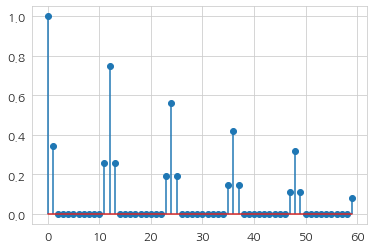

In [33]:
Phi = -0.75
Theta = 0.4
p6 = sm.tsa.ArmaProcess([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Phi], [1, Theta])
plt.stem(p6.acf(60), use_line_collection=True)
plt.show()

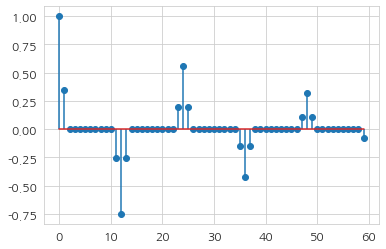

In [34]:
Phi = 0.75
Theta = 0.4
p7 = sm.tsa.ArmaProcess([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Phi], [1, Theta])
plt.stem(p7.acf(60), use_line_collection=True)
plt.show()

### 예 3: Multiplicated SARIMA(0,1,0)x(0,1,0,12)

이번에는 적분 요소가 있는 Multiplicated Seasonal ARIMA 모형을 살펴보자. 계절성 주기가 12 이고 계절성 성분끼리 1차 적분, 일반 성분 끼리 1차 적분인 모형은 SARIMA(0,1,0)x(0,1,0,12) 모형이다.

$$\nabla_s \nabla Y_t = \epsilon_t$$

$$\nabla_s ( Y_t - Y_{t-1} ) = \epsilon_t$$

$$( Y_{t} - Y_{t-1} ) - ( Y_{t-12} - Y_{t-13} ) = \epsilon_t$$

$$Y_{t} =  Y_{t-1} +  Y_{t-12} - Y_{t-13} + \epsilon_t$$

이 모형은 시계열을 차분하여 만든 새로운 시계열을 다시 12 시간 간격으로 계절성 차분한 시계열이 백색 잡음이라는 의미이다.

### 예 4: Multiplicated SARIMA(0,1,1)x(0,1,1,12)

이번에는 계절성 주기가 12 이고 일반 성분과 계절성 성분이 모두 ARIMA(0,1,1)인 SARIMA(0,1,1)x(0,1,1,12) 모형이다.

$$\nabla_s \nabla Y_t = (1 + \Theta L^{12})(1 + \theta L) \epsilon_t$$

$$\nabla_s ( Y_t - Y_{t-1} ) =  \epsilon_t + \theta \epsilon_{t-1} + \Theta \epsilon_{t-12} + \theta\Theta \epsilon_{t-13}$$

$$( Y_{t} - Y_{t-1} ) - ( Y_{t-12} - Y_{t-13} ) =  \epsilon_t + \theta \epsilon_{t-1} + \Theta \epsilon_{t-12} + \theta\Theta \epsilon_{t-13}$$

$$Y_{t} =  Y_{t-1} +  Y_{t-12} - Y_{t-13} +  \epsilon_t + \theta \epsilon_{t-1} + \Theta \epsilon_{t-12} + \theta\Theta \epsilon_{t-13}$$

이 모형은 시계열을 차분하여 만든 새로운 시계열을 다시 12 시간 간격으로 계절성 차분한 시계열이 위에서 보인 첫번째 예인 SARIMA(0,1,1)x(0,0,1,12) 모형이라는 의미이다.